# Prophet Python Baseline

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

In [12]:
# custom MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
# read data
raw_data = pd.read_csv("ESP Relief 2010 to April 17 2019.csv", parse_dates=["SHIFT_DATE"])

In [3]:
# create train, val, and test
train = raw_data[(raw_data["SHIFT_DATE"]>"2012-12-31") & (raw_data["SHIFT_DATE"]<"2017-01-01")]
val = raw_data[(raw_data["SHIFT_DATE"]>"2016-12-31") & (raw_data["SHIFT_DATE"]<"2018-01-01")]
test = raw_data[(raw_data["SHIFT_DATE"]>"2017-12-31") & (raw_data["SHIFT_DATE"]<"2019-01-01")]

In [4]:
# create count by day
train_count_by_day = train.groupby("SHIFT_DATE").size().reset_index()
train_count_by_day = train_count_by_day.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

val_count_by_day = val.groupby("SHIFT_DATE").size().reset_index()
val_count_by_day = val_count_by_day.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

test_count_by_day = test.groupby("SHIFT_DATE").size().reset_index()
test_count_by_day = test_count_by_day.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [5]:
# fit Prophet with train data
m = Prophet()
m.fit(train_count_by_day)

/Users/pokepoke4/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pokepoke4/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [7]:
# make future dataframe
future_val = m.make_future_dataframe(periods=365, freq="D")
future_val.tail()

,ds
1821,2017-12-27
1822,2017-12-28
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [8]:
# predict with future dataframe
forecast_val = m.predict(future_val)
forecast_val[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1821,2017-12-27,1645.290512,1414.169305,1863.745788
1822,2017-12-28,1572.756430,1325.900594,1795.578589
1823,2017-12-29,1630.938434,1400.278785,1860.331953
1824,2017-12-30,875.446645,635.245748,1101.036877
1825,2017-12-31,826.804275,609.059241,1060.938667


/Users/pokepoke4/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


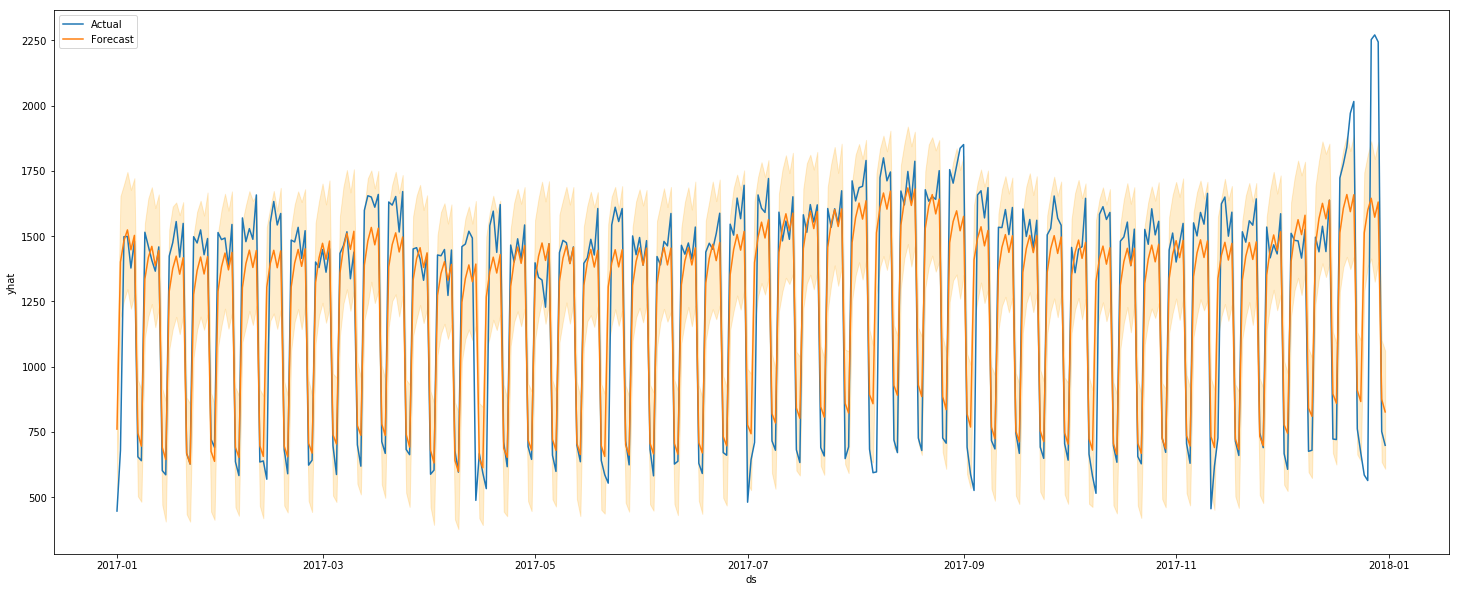

In [9]:
ax = plt.figure(figsize=(25,10))
ax = sns.lineplot(data=val_count_by_day, x="ds", y="y", label="Actual")
ax = sns.lineplot(data=forecast_val[forecast_val["ds"]>"2016-12-31"], x="ds", y="yhat", label="Forecast")
ax.fill_between(data=forecast_val[forecast_val["ds"]>"2016-12-31"], x="ds", y1='yhat_lower', y2='yhat_upper', color="orange", alpha=0.2)


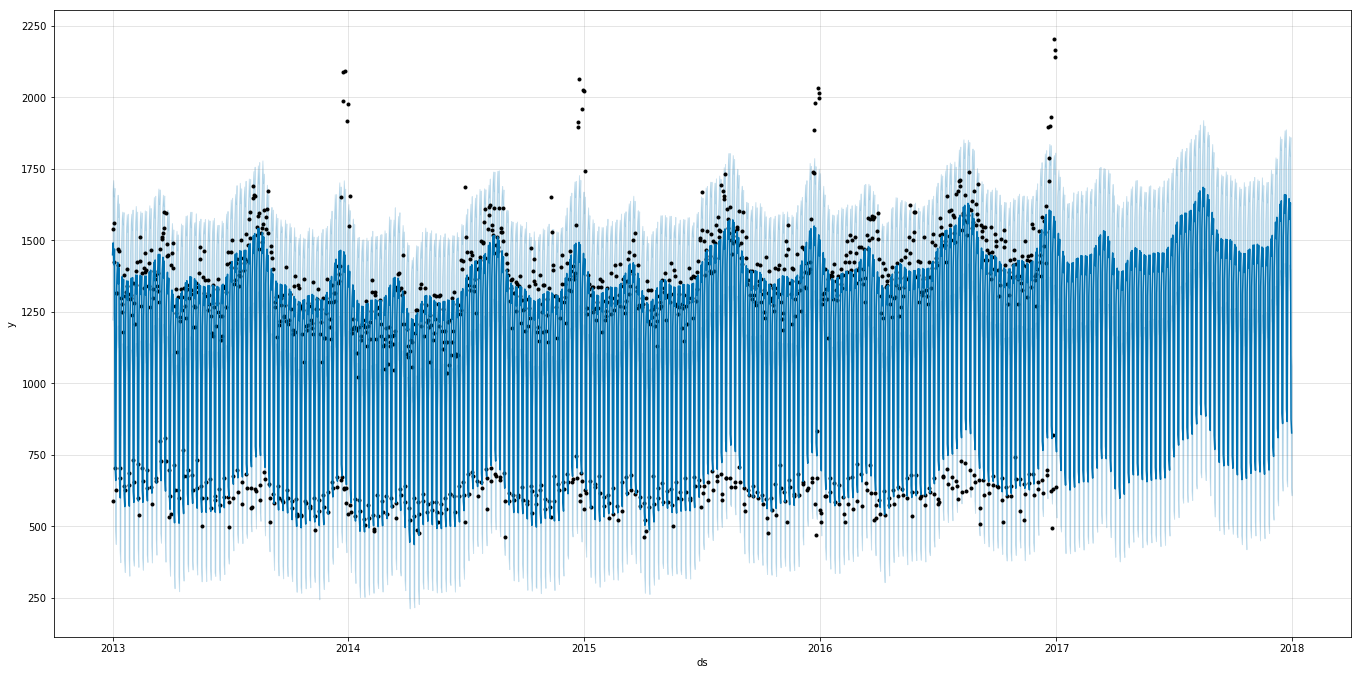

In [10]:
fig1 = m.plot(forecast_val)
fig1.set_size_inches(20, 10, forward=True)

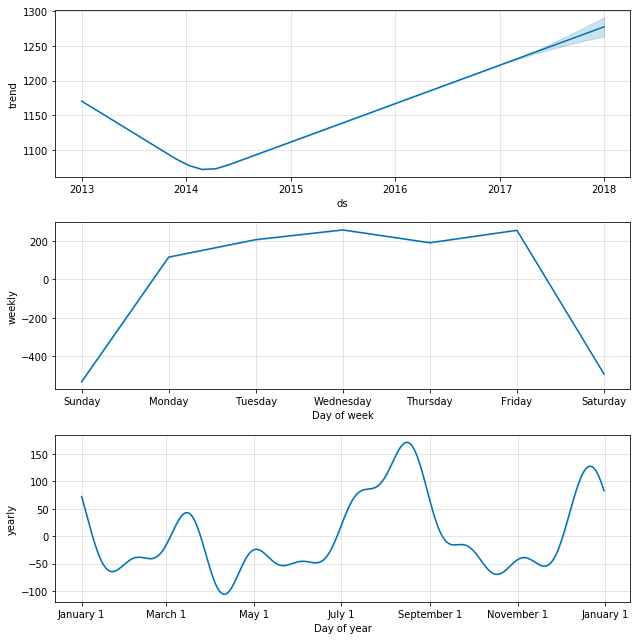

In [11]:
fig2 = m.plot_components(forecast_val)

In [13]:
# prediction
predictions_val = forecast_val[forecast_val["ds"] > "2016-12-31"]["yhat"]
mape(val_count_by_day['y'], predictions_val)

13.08507324411117

# Predictions of weekly with daily

In [14]:
predictions_val = forecast_val[forecast_val["ds"] > "2016-12-31"]
predictions_val["week"] = predictions_val["ds"].dt.weekofyear
predictions = predictions_val.groupby("week").yhat.sum().reset_index()

/Users/pokepoke4/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
val_count_by_day["week"] = val_count_by_day["ds"].dt.weekofyear
actual = val_count_by_day.groupby("week").y.sum().reset_index()

In [16]:
mape(actual["y"], predictions["yhat"])

3.9504145009296963